# MACHINE LEARNING MODELS - FEATURE IMPORTANCE - SEP LAYERS

In this notebook, we specifically examin feature importance of the various models.

In [1]:
# Import libraries and functions

#Data Science usual libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# Scikit-learn libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance

#OverSampling and UnderSampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

### Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# define random_state
RANDOM_STATE = 3
n_repeats = 30
%matplotlib inline

### 1. Load data

We load our csv into a dataframe using pandas.

In [2]:
## Define paths


dataDir = "data/"
separate_layers = "separate_layers.csv"

separate_layers = pd.read_csv(dataDir + separate_layers)

In [3]:
separate_layers.shape

(165, 104)

In [4]:
separate_layers.head()

,id,controls_ms,mstype,age,sex,dd,edss,FA_diameter,FA_gl-efficiency,FA_mean_path-length,...,FA_loc-clos-cent_ctx-rh-precentral,FA_loc-clos-cent_ctx-rh-rostralanteriorcingulate,FA_loc-clos-cent_ctx-rh-superiorfrontal,FA_loc-clos-cent_ctx-rh-supramarginal,FA_loc-clos-cent_ctx-rh-transversetemporal,GM_loc-strength_ctx-lh-rostralmiddlefrontal,fMRI_loc-clos-cent_ctx-lh-entorhinal,fMRI_loc-clos-cent_Right-Amygdala,fMRI_loc-clos-cent_ctx-rh-entorhinal,fMRI_loc-clos-cent_ctx-rh-paracentral
0,002MSVIS,PwMS,SPMS,51.53,Male,22.18,7.5,0.749329,2.723527,0.404413,...,0.032926,0.035895,0.034425,0.035408,0.034443,6.890250,0.262300,0.188231,0.224069,0.207830
1,003MSVIS,PwMS,PPMS,58.06,Female,9.57,6.0,0.685088,2.643900,0.405654,...,0.035146,0.034714,0.032668,0.033092,0.030905,8.385633,0.191097,0.164313,0.176306,0.269140
2,004MSVIS,PwMS,RRMS,60.78,Male,6.79,3.0,0.739964,2.652358,0.413579,...,0.033177,0.035793,0.033172,0.032197,0.033935,9.998207,0.228344,0.316949,0.198180,0.316036
3,005MSVIS,PwMS,RRMS,37.95,Female,8.45,1.5,0.857654,2.309886,0.464976,...,0.027081,0.028645,0.029161,0.028574,0.025907,9.298109,0.341972,0.307553,0.175626,0.183286
4,010MSVIS,PwMS,RRMS,52.64,Female,9.05,2.0,0.757653,2.576118,0.419794,...,0.032857,0.034034,0.034274,0.031715,0.030174,7.706899,0.239808,0.406199,0.337893,0.424529


In [5]:
all_data = separate_layers.copy()

## 2. Remove highly correlated data

Graph measures could exhibit high correlation (for example, diameter measures and mean path length, different centrality measures, and so on). Most machine learning algorithms perform better without highly correlated features. Therefore, we will remove any columns that are significantly correlated with others, retaining only one representative measure from each set of correlated measures.

We set our threshold at 0.8, accounting for both positive and negative correlations, and remove all correlated columns over (or below) threshold.

In [6]:
selected_columns = all_data.iloc[:, 7:] 
colnames = list(selected_columns)

pos_threshold = 0.8
neg_threshold = -0.8

highly_correlated_columns = {} #Dictionary to store correlations
columns_to_remove = []
for i,colname in enumerate(colnames):
    columns_to_dict = [] # Dictionary values
    if selected_columns.columns[i] not in columns_to_remove: #Column not in the list to remove
        for j in range(i+1, len(colnames)):
            if selected_columns.columns[j] not in columns_to_remove: #Column not in the list to remove
                matrix_coef = np.corrcoef(selected_columns.iloc[:, i], selected_columns.iloc[:, j]) 
                if matrix_coef[0,1] > pos_threshold or matrix_coef[0,1] < neg_threshold:
                    columns_to_remove.append(selected_columns.columns[j])
                    columns_to_dict.append(selected_columns.columns[j])
        highly_correlated_columns[colname] = columns_to_dict

columns_to_remove = set(columns_to_remove) #just in case we have some repeated columns
print("Can remove " +str(len(columns_to_remove)) + " features")

# Select column that are not in the list
filtered_columns = [col for col in selected_columns.columns if col not in columns_to_remove] 
filtered_df = selected_columns[filtered_columns]

# Final dataframe
final_data = pd.concat([all_data.iloc[:, :7], filtered_df], join = "inner", axis = 1)
final_data.head()


Can remove 86 features


,id,controls_ms,mstype,age,sex,dd,edss,FA_diameter,FA_gl-strength,fMRI_gl-efficiency,fMRI_mean_path-length,fMRI_gl-transitivity,FA_loc-clos-cent_ctx-rh-caudalanteriorcingulate,GM_loc-strength_ctx-lh-rostralmiddlefrontal,fMRI_loc-clos-cent_ctx-lh-entorhinal,fMRI_loc-clos-cent_Right-Amygdala,fMRI_loc-clos-cent_ctx-rh-entorhinal,fMRI_loc-clos-cent_ctx-rh-paracentral
0,002MSVIS,PwMS,SPMS,51.53,Male,22.18,7.5,0.749329,20.683822,34.887033,0.059262,0.975455,0.034447,6.890250,0.262300,0.188231,0.224069,0.207830
1,003MSVIS,PwMS,PPMS,58.06,Female,9.57,6.0,0.685088,21.561644,26.403461,0.061415,0.966835,0.036082,8.385633,0.191097,0.164313,0.176306,0.269140
2,004MSVIS,PwMS,RRMS,60.78,Male,6.79,3.0,0.739964,22.625097,29.982327,0.053033,0.960516,0.029814,9.998207,0.228344,0.316949,0.198180,0.316036
3,005MSVIS,PwMS,RRMS,37.95,Female,8.45,1.5,0.857654,22.236905,31.152743,0.055629,0.977091,0.029511,9.298109,0.341972,0.307553,0.175626,0.183286
4,010MSVIS,PwMS,RRMS,52.64,Female,9.05,2.0,0.757653,20.812184,31.347753,0.047155,0.964302,0.031297,7.706899,0.239808,0.406199,0.337893,0.424529


In [7]:
final_data.shape

(165, 18)

In [8]:
len_correlations ={key:len(highly_correlated_columns[key]) for key in highly_correlated_columns.keys()}
len_correlations

{'FA_diameter': 85,
 'FA_gl-strength': 0,
 'fMRI_gl-efficiency': 0,
 'fMRI_mean_path-length': 0,
 'fMRI_gl-transitivity': 1,
 'FA_loc-clos-cent_ctx-rh-caudalanteriorcingulate': 0,
 'GM_loc-strength_ctx-lh-rostralmiddlefrontal': 0,
 'fMRI_loc-clos-cent_ctx-lh-entorhinal': 0,
 'fMRI_loc-clos-cent_Right-Amygdala': 0,
 'fMRI_loc-clos-cent_ctx-rh-entorhinal': 0,
 'fMRI_loc-clos-cent_ctx-rh-paracentral': 0}

## 2. Define functions

We define some functions we will use throught the notebook

It is worth noting that in our pipepline needs scaling (normalize) our values, as SMOTE and machine learning models perform better with normalized values



In [9]:
def make_pipeline(model, num_neighbors = 5):
    """
    Function that creates a pipeline with Standard Scaler, SMOTE and model selected
    INPUT 
    model --> a scikit model like RandomForestClassifier()
    num_neighbors --> an int, default 5. Indicates number of neighbors SMOTE will use
    
    Returns 
    a pipeline from imblearn
    """
    over = SMOTE(random_state = RANDOM_STATE, k_neighbors= num_neighbors)    
    sc = StandardScaler()
    model = model
    steps = [('Scaler', sc), ('over', over), ('model', model)]
    pipeline = Pipeline(steps = steps)
    
    return pipeline

def search_grid(model, param_grid, num_neighbors = 5):
    """
    Function to perfrom GridSearchCV on a model.
    
    INPUT: 
    model --> a scikit model like RandomForestClassifier()
    param_grid --> a dict with parameters to perform GridSearchCV
    num_neighbors --> an int, default 5. Indicates number of neighbors SMOTE will use
    
    CALLS make_pripeline 
    
    PRINTS  GridSearchCV best parameters
    
    RETURNS GridSearchCV result
    
    """
  # Depending if we are doing a binary classification (HS - PWMS) o multiclass (different MStypes)
  # we choose a scoring type
    if len(le_name_mapping.keys()) > 2:
        scoring = "f1_weighted"
    else:
        scoring = "f1"

    #Perform Grid Search    
    GridSearch_model = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring = scoring)
    pipeline = make_pipeline(GridSearch_model, num_neighbors = num_neighbors)
    pipeline.fit(X_train, y_train) 
    
    
    print(GridSearch_model.best_params_)
    
    return GridSearch_model

def plot_hist_GridSearch(means, model_name):
    """
    Function to plot a histogram from a list of means that represent Mean Test Scores 
    from GridSearchCV
    INPUT
    means --> a list of numbers
    model_name <- a string to identify model
    """
    #plt.hist(scores, bins = 10)
    sns.histplot(means, bins=10)
    xmin = min(means)
    if xmin > 0.9:
        xmin = 0.9
    plt.xlim(xmin, 1)
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.title(model_name, fontsize = 18)

In [10]:

def perm_impor_bar(model, model_name, classification = "HS vs PwMS"):
    if len(le_name_mapping.keys()) > 2:
        scoring = "f1_weighted"
    else:
        scoring = "f1"
    results = permutation_importance(model, X_test, y_test, scoring = scoring, n_repeats=n_repeats,
                               random_state= RANDOM_STATE)
    
    plot_title = 'SEPARATE LAYERS Permutation importace '+model_name+ ' '+classification
    file ="images/SEPperm_imp_bar_"+classification+"_"+model_name+".png"
    
    perm = pd.DataFrame(columns=['AVG_Importance', 'STD_Importance'], 
                        index=[i for i in X.columns])
    perm['AVG_Importance'] = results.importances_mean
    perm['STD_Importance'] =results.importances_std
    
  
    
    perm = perm.sort_values('AVG_Importance', ascending = False)
    
    
    
    perm = perm[perm['AVG_Importance'] != 0]
    
    #Create colors
    perm['color'] = ['blue' if i == 0 else 'red' if i == len(perm) -1 else 'orange' for i in range(len(perm))]

    if perm.empty:
        print("All features are zero")
    else:
        plt.figure(figsize=(14, 10))
        sns.barplot(x = perm['AVG_Importance'], y = perm.index, palette = perm['color'] )
        plt.title(plot_title, fontsize = 20)
        plt.xlabel("Average of Importance.", fontsize = 16)
        plt.tick_params(axis='y', labelsize=16)
        plt.savefig(file, bbox_inches='tight')
        plt.show()
        return(perm)


## 3. BINARY CLASSIFICATION 
## Healthy Subjects (HS) and Patients with Multiple Sclerosis (PwMS)

In this section, we will deploy machine learning models to attempt to distinguish between healthy subjects and patients with Multiple Sclerosis, without differentiating patients by their specific illness phenotype

First we divide our dataset in train and test. 

In [11]:
X = final_data.iloc[:,7:]
y = final_data["controls_ms"]

# Our values are encoded in labels rather than in 0s and 1s, so we use label encoder
le = LabelEncoder()
y = le.fit_transform(y)

#We need to make a change to use permutation_importance
features = X.columns
X_perm = X.values

# Create a dictionary with correspondences between labels and encoded labels
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_))) 


X_train, X_test, y_train, y_test = train_test_split(X_perm, y, test_size=0.2, random_state= RANDOM_STATE)

### 3.1. RANDOM FOREST FOR BINARY CLASSIFICATION

In [12]:
param_grid = {
    'n_estimators': [25, 50, 75, 100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 5, 7, 10, 15]
}

GridSearch_RF = search_grid(RandomForestClassifier(random_state = RANDOM_STATE), param_grid)
max_depth = GridSearch_RF.best_params_['max_depth']
max_features = GridSearch_RF.best_params_['max_features']
n_estimators = GridSearch_RF.best_params_['n_estimators']
model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, 
                               max_features = max_features, 
                               random_state = RANDOM_STATE)
pipeline = make_pipeline(model, num_neighbors = 5)
pipeline.fit(X_train, y_train)


{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 150}


Pipeline(steps=[('Scaler', StandardScaler()), ('over', SMOTE(random_state=3)),
                ('model',
                 RandomForestClassifier(max_depth=10, n_estimators=150,
                                        random_state=3))])

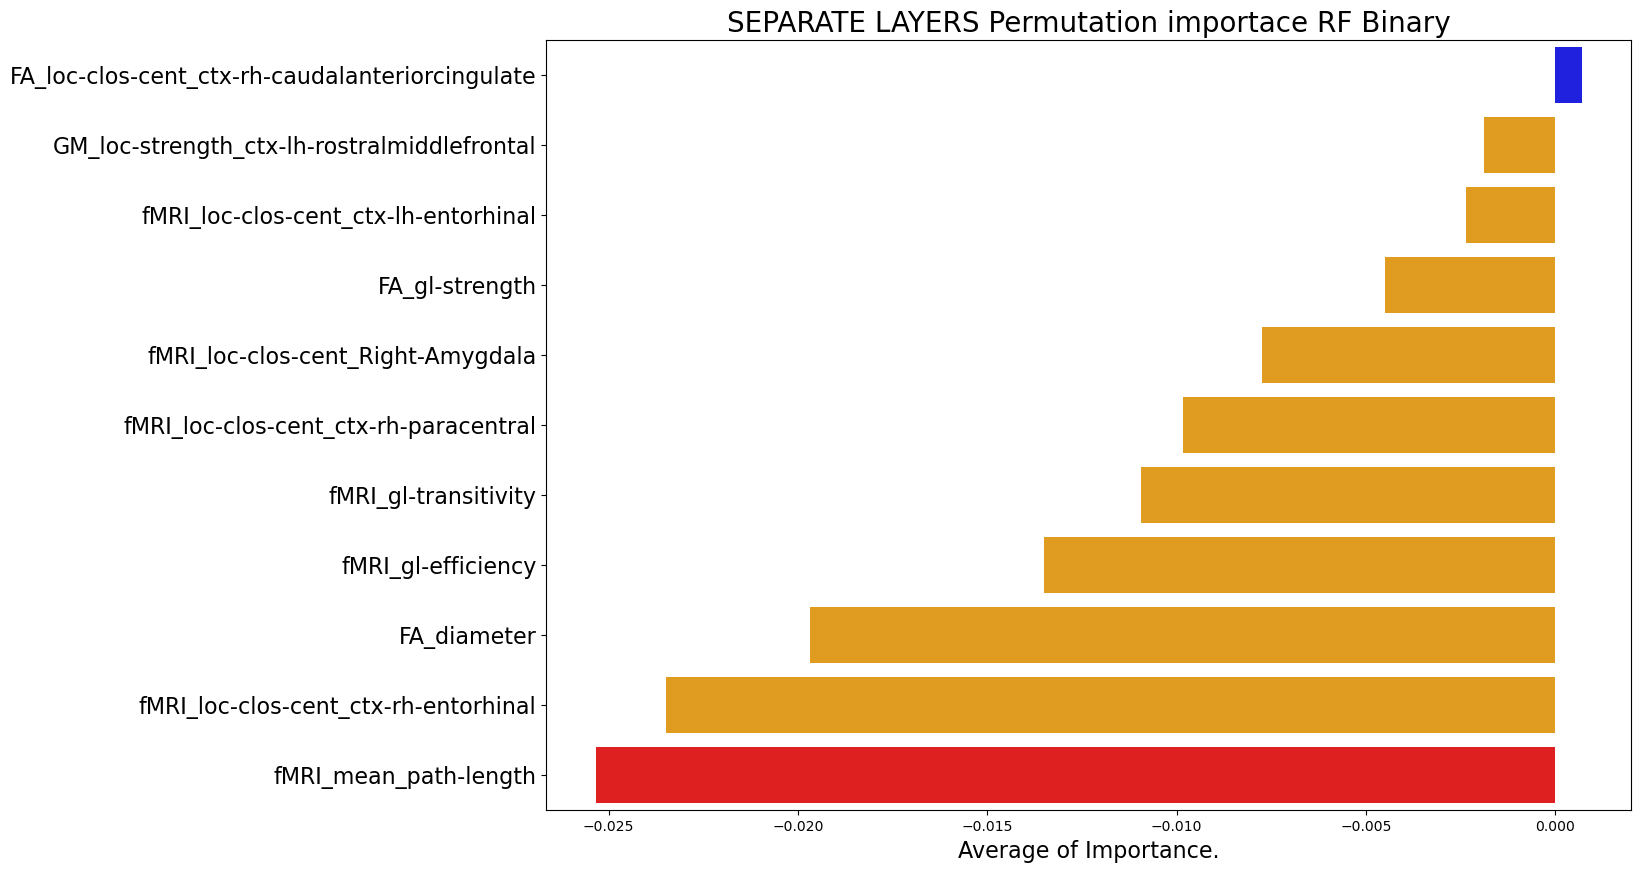

In [13]:
test_rf_bar = perm_impor_bar(pipeline, "RF", "Binary")

### 3.2. XGBOOST FOR BINARY CLASSIFICATION

In [14]:
param_grid =[{"learning_rate": [0.20, 0.25, 0.30],
              "max_depth": [4, 5, 6, 7],
                     "min_child_weight": [ 1, 3],
                     "gamma": [0.0, 0.05, 0.1, 0.2],
                     "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
                     "verbosity": [0]}]# add this line to slient warning message
importance_list = []


GridSearch_XGB = search_grid(XGBClassifier(random_state = RANDOM_STATE), param_grid)
learning_rate = GridSearch_XGB.best_params_["learning_rate"]
max_depth = GridSearch_XGB.best_params_["max_depth"]
min_child_weight =GridSearch_XGB.best_params_["min_child_weight"]
gamma = GridSearch_XGB.best_params_["gamma"]
colsample_bytree = GridSearch_XGB.best_params_["colsample_bytree"]
model = XGBClassifier(random_state = RANDOM_STATE,
                        learning_rate = learning_rate, 
                      max_depth = max_depth,
                     min_child_weight = min_child_weight,
                     gamma = gamma,
                     colsample_bytree = colsample_bytree,
                     verbosity = 0)
pipeline = make_pipeline(model, num_neighbors = 5)
pipeline.fit(X_train, y_train)

{'colsample_bytree': 0.4, 'gamma': 0.0, 'learning_rate': 0.25, 'max_depth': 6, 'min_child_weight': 1, 'verbosity': 0}


Pipeline(steps=[('Scaler', StandardScaler()), ('over', SMOTE(random_state=3)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.4, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.25,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=3, ...))])

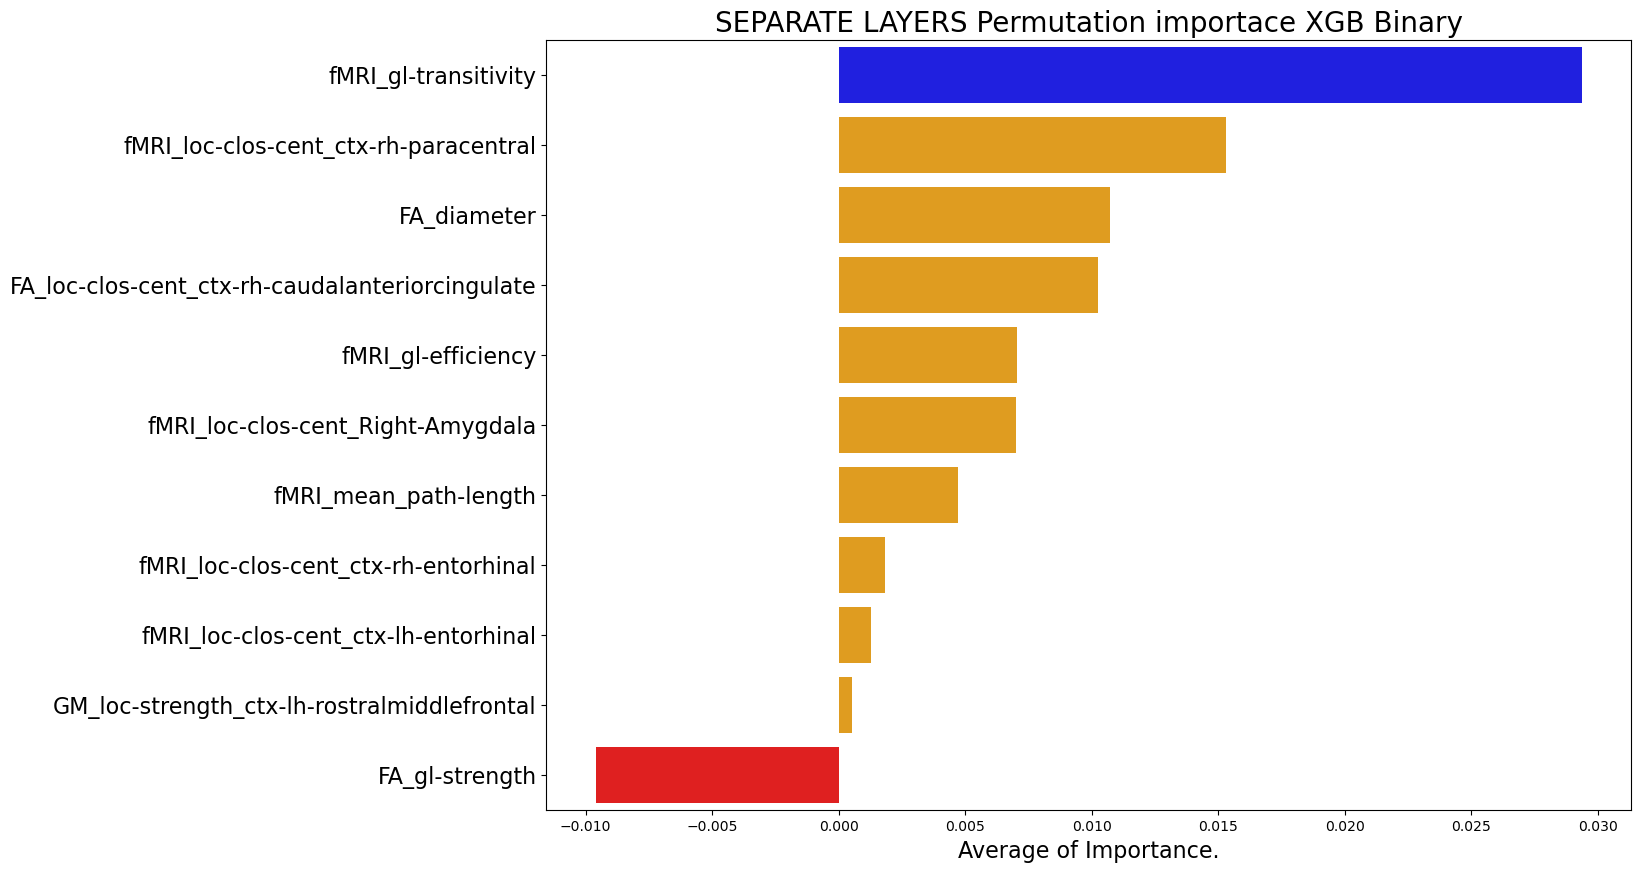

In [15]:
test_XGB_bar = perm_impor_bar(pipeline, "XGB", "Binary")